<h1> Capstone Project: Battle of the Neighborhoods

<h1> Introduction

For this Capstone Project, I will be leveraging the Foursquare location data in order to determine optimal places to open a Restaurant in the Houston Area. I will be looking at specific neighborhoods in the area to determine whether a neighborhood is viable by comparing the variety of venues available, as well as the amount of competition for Japanese Restaurants. This will serve as a great demonstration on the use of the Foursquare API in order to solve business problems.


<h1>Data

Using the Foursquare API I will be able to obtain information on various venues available in the Houston area. With this information, I hope to be able to group neighborhoods into clusters with similar venue makeup, and analyzing which clusters are able to sustain a new Restaurant.
For breaking down the Houston Area into individual neighborhoods, we can webscrape information using websites such as Wikipedia.

<h1> Methodology
    

Let's begin by loading the neighborhood information for the Houston Area. This will be accomplished by webscraping relevant Wikipedua pages for location names, and then passing them into the geopy package to retrieve longitude and latitude values.

In [52]:
!pip install beautifulsoup4
import warnings

import pandas as pd
import requests
import numpy as np
import sklearn
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
!pip install geopy
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
warnings.filterwarnings("ignore", category=DeprecationWarning) 



In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Houston'
text = requests.get(url).text
soup = BeautifulSoup(text,'html')

In [3]:
neigh = []
table = soup.find('table')
for row in table.find_all('td'):
        x = {}
        x['Neighborhood'] = row.text.strip("\n")
        neigh.append(x)
df = pd.DataFrame(neigh)
df = df[1::4]


In [4]:
coord = []
for nhood in df['Neighborhood']:
    address = '{}, TX'.format(nhood)
    geolocator = Nominatim(user_agent="tx_explorer")
    location = geolocator.geocode(address)
    if location is None:
        df = df.loc[df["Neighborhood"] != nhood]
    else:
        x = {}
        x['Latitude'] = location.latitude
        x['Longitude'] = location.longitude
        coord.append(x)

In [5]:

df.reset_index(inplace=True,drop=True)
df['Latitude'] = pd.DataFrame(coord)['Latitude']
df['Longitude'] = pd.DataFrame(coord)['Longitude']
df.head()

,Neighborhood,Latitude,Longitude
0,Willowbrook,29.967445,-95.538830
1,Greater Greenspoint,29.944719,-95.416074
2,Carverdale,29.848687,-95.539450
3,Fairbanks / Northwest Crossing,29.852726,-95.524386
4,Acres Home,32.508056,-94.686509


Now we will visualize the information by creating a folium map an highlighting the center of the neighborhoods.

In [6]:
!pip install folium
import folium

In [7]:
address = 'Houston, TX'
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
map_houston = folium.Map(location=[latitude, longitude], zoom_start=11)
for lat, lng, neighborhood in zip(df['Latitude'], df['Longitude'], df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_houston)  
map_houston

Now we will gather information on venues using the Foursquare API. Afterwards we will cluster the neighborhoods based on the data in hopes to reveal any patterns that can aid us in finding an optimal location. We will group clusters based on the most popular venues available in specific neighborhoods.

In [8]:
CLIENT_ID = 'VCOM31OONUJTTEIKZ0GGW1DOLGGNHRHJFDYVMMEZPVKDMOK4' 
CLIENT_SECRET = 'SOSRYCYZP5K22G4CD3HSZLRGGA3Z2HAALCNQFSFWAETBTCUB' 
VERSION = '20180605' 
LIMIT = 100

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [9]:
venues = getNearbyVenues(df['Neighborhood'],df['Latitude'],df['Longitude'])

In [32]:

HTX_onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")
HTX_onehot['Neighborhood'] = venues['Neighborhood'] 

fixed_columns = [HTX_onehot.columns[-1]] + list(HTX_onehot.columns[:-1])
HTX_onehot = HTX_onehot[fixed_columns]
HTX_onehot.head()


,Neighborhood,Accessories Store,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Arcade,Art Gallery,...,Toll Booth,Toy / Game Store,Trail,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,Willowbrook,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Willowbrook,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Willowbrook,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Willowbrook,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Willowbrook,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


As we can see, Foursquare was able to retrieve 544 venues. However, based on the number of venue categories, this may not be enough data to properly group the neighborhoods. 

In [38]:

HTX_grouped = HTX_onehot.groupby('Neighborhood').mean().reset_index()
HTX_grouped.head()



,Neighborhood,Accessories Store,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Arcade,Art Gallery,...,Toll Booth,Toy / Game Store,Trail,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,Acres Home,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.25,0.0,0.000000,0.0,0.0,0.0,0.0
1,Addicks / Park Ten,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.055556,0.0,0.0,0.0,0.0
2,Afton Oaks / River Oaks,0.0,0.0,0.0,0.0,0.0,0.0,0.083333,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0
3,Alief,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0
4,Braeburn,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0


In [12]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]


In [13]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
top_venues = pd.DataFrame(columns=columns)
top_venues['Neighborhood'] = HTX_grouped['Neighborhood']

for ind in np.arange(HTX_grouped.shape[0]):
    top_venues.iloc[ind, 1:] = return_most_common_venues(HTX_grouped.iloc[ind, :], num_top_venues)

top_venues.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Acres Home,Bakery,Video Game Store,Rental Service,Accessories Store,New American Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motel,Motorcycle Shop,Movie Theater
1,Addicks / Park Ten,Hotel,Indian Restaurant,Coffee Shop,Sushi Restaurant,Shipping Store,Burger Joint,Vietnamese Restaurant,Intersection,Pizza Place,Motel
2,Afton Oaks / River Oaks,Cajun / Creole Restaurant,Rental Car Location,Deli / Bodega,BBQ Joint,Pizza Place,American Restaurant,Chinese Restaurant,Seafood Restaurant,Optical Shop,Movie Theater
3,Alief,Pool,Playground,Football Stadium,New American Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motel,Motorcycle Shop,Movie Theater,Museum
4,Braeburn,Mexican Restaurant,Coffee Shop,Construction & Landscaping,Mobile Phone Shop,Motel,Motorcycle Shop,Movie Theater,Museum,Music Venue,New American Restaurant


Having gathered the venues data and properly represented them in the dataframe above, we can now proceed to try and group them. We will be employing the kmeans method in order to group the neighborhoods. First, we will repeat the process through various k-values. We will then find an optimal k-value using the elbow-method. Finally, with the approriate k-value, we will group the neighborhoods and analyze the created clusters

In [40]:
HTX_clust = HTX_grouped.drop('Neighborhood', 1)
k = range(2,10)
dist = []
for K in k:
    kmeans = KMeans(n_clusters=K, random_state=0).fit(HTX_clust)
    kmeans.inertia_
    dist.append(kmeans.inertia_)


/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


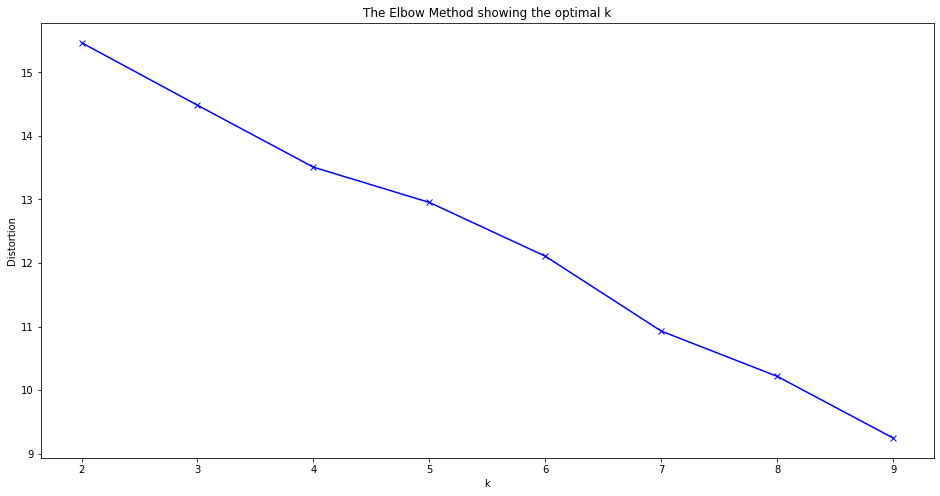

In [41]:
plt.figure(figsize=(16,8))
plt.plot(k, dist, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

It is hard to tell based on the elbow test above what an optimal k value is, but we will be using the values of 6 to continue the kameans clustering. This confirms our previous assumption that Foursquare was not able to retrieve enough data. 

In [17]:
k = 6
kmeans = KMeans(n_clusters=k, random_state=0).fit(HTX_clust)

top_venues.insert(0, 'Cluster Labels', kmeans.labels_)
merged_data = df
merged_data = merged_data.join(top_venues.set_index('Neighborhood'), on='Neighborhood')
merged_data.dropna(inplace = True)
merged_data.head()

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Willowbrook,29.967445,-95.538830,2.0,Burger Joint,Sporting Goods Shop,Fast Food Restaurant,Chinese Restaurant,Furniture / Home Store,Deli / Bodega,Spa,Clothing Store,Big Box Store,Cajun / Creole Restaurant
1,Greater Greenspoint,29.944719,-95.416074,2.0,Pizza Place,Shoe Store,Department Store,Café,Supplement Shop,Theme Park,Gym,Men's Store,Movie Theater,Mexican Restaurant
2,Carverdale,29.848687,-95.539450,2.0,Locksmith,Electronics Store,Park,Accessories Store,New American Restaurant,Mobile Phone Shop,Motel,Motorcycle Shop,Movie Theater,Museum
3,Fairbanks / Northwest Crossing,29.852726,-95.524386,2.0,BBQ Joint,Taco Place,Hardware Store,Accessories Store,Miscellaneous Shop,Mobile Phone Shop,Motel,Motorcycle Shop,Movie Theater,Museum
4,Acres Home,32.508056,-94.686509,1.0,Bakery,Video Game Store,Rental Service,Accessories Store,New American Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motel,Motorcycle Shop,Movie Theater


Now that we have our clusters, we will proceed to visualize them on our folium map and then, individually inspect their features to see if we can find an optimal location for a new restaurant.

In [18]:
address = 'Houston, TX'
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]



In [42]:
markers_colors = []
for lat, lon, poi, cluster in zip(merged_data['Latitude'], merged_data['Longitude'], merged_data['Neighborhood'], merged_data['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<h3> Cluster 1
    
    

In [45]:
merged_data.loc[merged_data['Cluster Labels']==0, merged_data.columns[[0] + list(range(5, merged_data.shape[1]))]]

,Neighborhood,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
36,East Houston,Accessories Store,Nightclub,Mobile Phone Shop,Motel,Motorcycle Shop,Movie Theater,Museum,Music Venue,New American Restaurant


<h3> Cluster 2
    

In [46]:
merged_data.loc[merged_data['Cluster Labels']==1, merged_data.columns[[0] + list(range(5, merged_data.shape[1]))]]

,Neighborhood,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Acres Home,Video Game Store,Rental Service,Accessories Store,New American Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motel,Motorcycle Shop,Movie Theater
8,Spring Branch West,IT Services,Park,Fried Chicken Joint,Food Truck,Bakery,Thrift / Vintage Store,Karaoke Bar,Convenience Store,Donut Shop
13,Eldridge / West Oaks,Pizza Place,Donut Shop,Intersection,Mexican Restaurant,Accessories Store,Mobile Phone Shop,Motel,Motorcycle Shop,Movie Theater
22,Braeburn,Coffee Shop,Construction & Landscaping,Mobile Phone Shop,Motel,Motorcycle Shop,Movie Theater,Museum,Music Venue,New American Restaurant
25,Medical Center,New American Restaurant,Burger Joint,Smoothie Shop,Coffee Shop,Gourmet Shop,Fried Chicken Joint,Sandwich Place,Gym,Café
26,South Main,Donut Shop,Lawyer,Mexican Restaurant,Accessories Store,Mobile Phone Shop,Motel,Motorcycle Shop,Movie Theater,Museum
44,Downtown,Italian Restaurant,Steakhouse,Gastropub,Brewery,Coffee Shop,Museum,Seafood Restaurant,Bar,Sandwich Place
45,Midtown,Pizza Place,Hotel,Gay Bar,Italian Restaurant,Jewelry Store,Food Truck,Bakery,New American Restaurant,Mobile Phone Shop
46,Second Ward,American Restaurant,Flower Shop,Mexican Restaurant,General Entertainment,Light Rail Station,Brewery,Japanese Restaurant,Motel,Movie Theater
58,Magnolia Park,Athletics & Sports,Park,Fast Food Restaurant,Fried Chicken Joint,Discount Store,Italian Restaurant,Paper / Office Supplies Store,Movie Theater,Insurance Office


<h3> Cluster 3

In [47]:
merged_data.loc[merged_data['Cluster Labels']==2, merged_data.columns[[0] + list(range(5, merged_data.shape[1]))]]

,Neighborhood,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Willowbrook,Sporting Goods Shop,Fast Food Restaurant,Chinese Restaurant,Furniture / Home Store,Deli / Bodega,Spa,Clothing Store,Big Box Store,Cajun / Creole Restaurant
1,Greater Greenspoint,Shoe Store,Department Store,Café,Supplement Shop,Theme Park,Gym,Men's Store,Movie Theater,Mexican Restaurant
2,Carverdale,Electronics Store,Park,Accessories Store,New American Restaurant,Mobile Phone Shop,Motel,Motorcycle Shop,Movie Theater,Museum
3,Fairbanks / Northwest Crossing,Taco Place,Hardware Store,Accessories Store,Miscellaneous Shop,Mobile Phone Shop,Motel,Motorcycle Shop,Movie Theater,Museum
5,Hidden Valley,Rental Service,Accessories Store,Nightclub,Miscellaneous Shop,Mobile Phone Shop,Motel,Motorcycle Shop,Movie Theater,Museum
6,Westbranch,Park,Clothing Store,Accessories Store,Mobile Phone Shop,Motel,Motorcycle Shop,Movie Theater,Museum,Music Venue
7,Addicks / Park Ten,Indian Restaurant,Coffee Shop,Sushi Restaurant,Shipping Store,Burger Joint,Vietnamese Restaurant,Intersection,Pizza Place,Motel
11,Greater Heights,Bar,Fast Food Restaurant,Flea Market,Gas Station,Seafood Restaurant,Accessories Store,Mobile Phone Shop,Motel,Motorcycle Shop
12,Memorial,Accessories Store,New American Restaurant,Mexican Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motel,Motorcycle Shop,Movie Theater,Museum
14,Briar Forest,Construction & Landscaping,Accessories Store,Optical Shop,Mobile Phone Shop,Motel,Motorcycle Shop,Movie Theater,Museum,New American Restaurant


<h3> Cluster 4

In [48]:
merged_data.loc[merged_data['Cluster Labels']==3, merged_data.columns[[0] + list(range(5, merged_data.shape[1]))]]

,Neighborhood,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Independence Heights,Accessories Store,Nightclub,Mobile Phone Shop,Motel,Motorcycle Shop,Movie Theater,Museum,Music Venue,New American Restaurant


<h3> Cluster 5

In [49]:
merged_data.loc[merged_data['Cluster Labels']==4, merged_data.columns[[0] + list(range(5, merged_data.shape[1]))]]

,Neighborhood,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
38,Northside Village,Accessories Store,New American Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motel,Motorcycle Shop,Movie Theater,Museum,Music Venue


<h3> Cluster 6

In [50]:
merged_data.loc[merged_data['Cluster Labels']==5, merged_data.columns[[0] + list(range(5, merged_data.shape[1]))]]

,Neighborhood,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,Westchase,Accessories Store,Nightclub,Miscellaneous Shop,Mobile Phone Shop,Motel,Motorcycle Shop,Movie Theater,Museum,Music Venue


Now by analyzing these clusters, we can see that neighboorhoods belonging to clusters 2 and 3, may have too much competition to start a new restaurant, where as neighborhoods such as Northside Village, or East Houston offers limited competition while still containing a variety of venues to have enough traffic for sustaining a business.

<h1> Results and Discussion

Based on the results, my opinion is to make is to start a new restaurant in locations such as East Houston or Westchase. The primary reason being that based on the popular venues, there are less competition for restaurant businesses. This coupled with a variety of venues to induce traffic can aid in sustaining a business. 

However, this conclusion is flawed due to the fact that we were only able to retrieve a limited amount of venues using the Foursquare API. There were too many uniques values which made the clustering algorithm not be able to produce efficient groupings for effective analysis. Our analysis is very much limited by the data which we are able to gather. With that being said, the proof of concept is here and stakeholders can leverage this method to aid them in many business decisions.

<h1> Conclusion

The purpose of this project is to demonstrate the value of leveraging the Foursquare API to gather data in order to produce informed business decision, such as opening a new restaurant. Using Foursquare, we obtained information on venues for multiple places and using available python packages, analyzed the neighborhoods to determine an optimal location.

However, this type of analysis is limited by the quantity and quality of our data. In this specific example, We can see that we could not obtain enough data to produce high quality clusters of neighborhoods. A solution to this problem can be to manipulate the available data to narrow down unique category tags to hepl out the clustering algorithm.

